In [1]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Automatically created module for IPython interactive environment
Usage: __main__.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.
Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories

Extracting features from the training dataset using a sparse vectorizer
done in 1.370068s
n_samples: 3387, n_features: 10000

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=Tru

In [2]:
dataset.keys()

dict_keys(['target_names', 'target', 'filenames', 'description', 'data', 'DESCR'])

In [3]:
opts

<Values at 0x105e24240: {'minibatch': True, 'n_features': 10000, 'use_idf': True, 'use_hashing': False, 'verbose': False, 'n_components': None}>

In [4]:
km.cluster_centers_

array([[  1.11360155e-03,   1.53013976e-03,   0.00000000e+00, ...,
          2.87209625e-05,   0.00000000e+00,   0.00000000e+00],
       [  1.98277612e-03,   3.12803103e-03,   1.97945580e-05, ...,
          4.39787878e-05,   0.00000000e+00,   9.69403687e-05],
       [  1.82735338e-03,   2.29142450e-03,   2.73046361e-04, ...,
          2.56732122e-04,   6.03526306e-04,   6.87376550e-04],
       [  1.66079441e-04,   1.44127217e-03,   0.00000000e+00, ...,
          5.70248615e-04,   0.00000000e+00,   6.02708296e-04]])

In [5]:
order_centroids[1, :]

array([8369, 6096, 4320, ..., 6374, 6373, 6436])

In [6]:
X

<3387x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 318592 stored elements in Compressed Sparse Row format>

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

colors = ListedColormap(['red', 'yellow', 'green'])
light_colors = ListedColormap(['lightcoral', 'lightyellow', 'lightgreen'])

def get_meshgrid(data, step=.05, border=.5,):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def plot_decision_surface(estimator, train_data, train_labels,
                          colors = colors, light_colors = light_colors):
    #fit model
    estimator.fit(train_data, train_labels)
    
    #set figure size
    plt.figure(figsize = (16, 6))
    
    #plot decision surface on the train data 
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
#     print(len(xx[0]))
#     print(len(np.c_[xx.ravel(), yy.ravel()]))
#     estimator.predict(np.c_[xx.ravel(), yy.ravel()])
#     mesh_predictions = np.array(estimator.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
#     plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
#     print(train_data[1])
#     plt.scatter(train_data[:, 0], train_data[:, 1], s = 100, cmap = colors)
#     plt.title('Train data, accuracy={:.2f}'.format(metrics.accuracy_score(train_labels, estimator.predict(train_data))))
    
plot_decision_surface(km, X, labels)

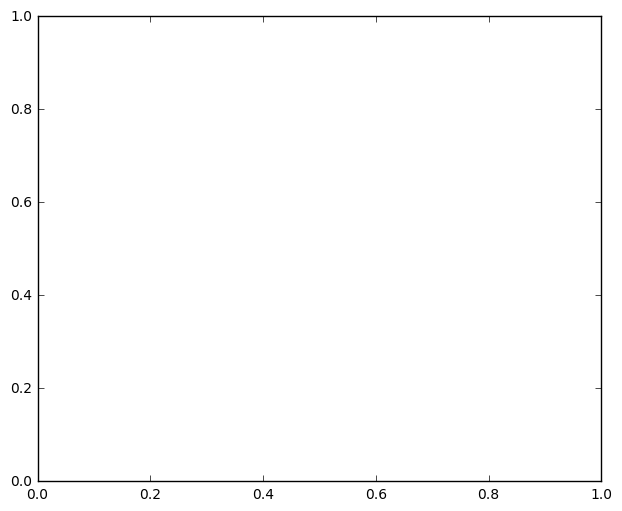

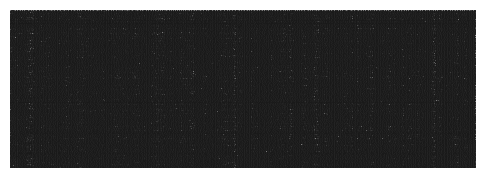

In [8]:
from scipy.sparse import coo_matrix

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
        fig = plt.figure()
        ax = fig.add_subplot(111, axisbg='black')
        ax.plot(m.col, m.row, 's', color='white', ms=1)
        ax.set_xlim(0, m.shape[1])
        ax.set_ylim(0, m.shape[0])
        ax.set_aspect('equal')
    for spine in ax.spines.values():
            spine.set_visible(False)
            ax.invert_yaxis()
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])
    return ax
ax = plot_coo_matrix(X)
# ax.figure.show()
plt.show()

[[ 0.1767767   0.15987221  0.          0.          0.          0.15987221
   0.          0.125       0.1767767   0.27181198  0.          0.          0.125
   0.          0.125       0.          0.125       0.27181198]
 [ 0.          0.          0.          0.26746955  0.26746955  0.
   0.26746955  0.          0.          0.          0.          0.          0.
   0.59677497  0.          0.          0.          0.        ]
 [ 0.          0.          0.59677497  0.          0.          0.          0.
   0.          0.          0.          0.26746955  0.26746955  0.          0.
   0.          0.26746955  0.          0.        ]]
[[  5.16573747e-17   4.60299280e+01]
 [ -3.98630828e+01  -2.30149640e+01]
 [  3.98630828e+01  -2.30149640e+01]]


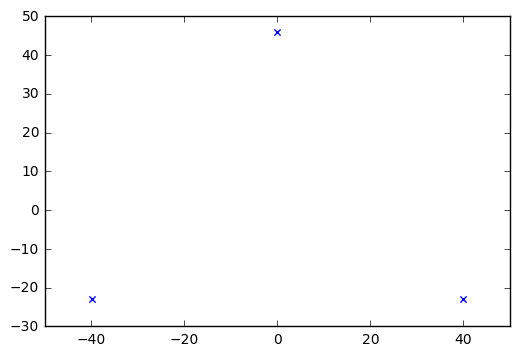

In [9]:
from sklearn.manifold import TSNE

train = ["is this good?", "this is bad", "some other text here", "i am hero", "blue jeans", "red carpet", "red dog",
     "blue sweater", "red hat", "kitty blue"]

vect = TfidfVectorizer()  
X = vect.fit_transform(train)
clf = KMeans(n_clusters=3)
data = clf.fit(X)
centroids = clf.cluster_centers_

tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1
model = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
         early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed_centroids = model.fit_transform(centroids)
print(centroids)
print(transformed_centroids)
plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker='x')
plt.show()

In [10]:
def plot_kmeans(centroids):
    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 1000
    random_state = 1
    model = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
             early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

    transformed_centroids = model.fit_transform(centroids)
    print(transformed_centroids)
    plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker='x')
    plt.show()

[[ 206529.20616858  -45599.13167119]
 [ -79988.4851996   234510.61241404]
 [-182637.89837925 -162410.47587524]
 [  56097.17741028  -26501.0048676 ]]


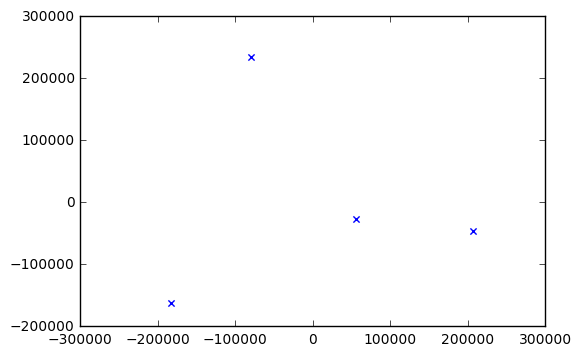

In [11]:
plot_kmeans(order_centroids)

In [13]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

newsgroups_train = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)
pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
        ('tfidf', TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf))
])        
X = pipeline.fit_transform(newsgroups_train.data).todense()

kmeans = KMeans(n_clusters=4).fit(X)
pca = PCA(n_components=4).fit(X)

centers2D = pca.transform(kmeans.cluster_centers_)

data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=newsgroups_train.target)

# plt.hold(True)
# plt.scatter(centers2D[:,0], centers2D[:,1], 
#             marker='x', s=200, linewidths=3, c='r')
plt.show()              #not required if using ipython notebook

KeyboardInterrupt: 

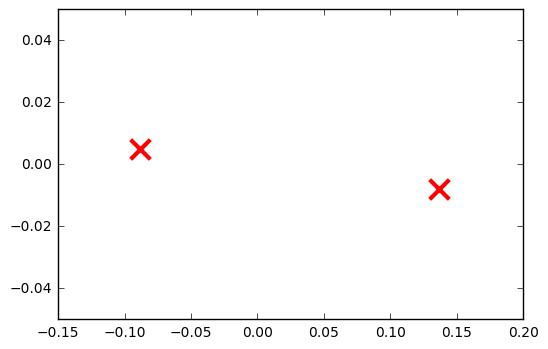

In [3]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(X)
centers2D = pca.transform(kmeans.cluster_centers_)

plt.hold(True)
plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.show()              #not required if using ipython notebook

In [25]:
import numpy as np
from matplotlib import pyplot as plt

# This generates 100 variables that could possibly be assigned to 5 clusters
n_variables = 100
n_clusters = 5
n_samples = 1000

# To keep this example simple, each cluster will have a fixed size
cluster_size = n_variables / n_clusters

# Assign each variable to a cluster
belongs_to_cluster = np.repeat(range(n_clusters), cluster_size)
np.random.shuffle(belongs_to_cluster)

# This latent data is used to make variables that belong
# to the same cluster correlated.
latent = np.random.randn(n_clusters, n_samples)

variables = []
for i in range(n_variables):
    variables.append(
        np.random.randn(n_samples) + latent[belongs_to_cluster[i], :]
    )

variables = np.array(variables)

C = np.cov(variables)

def score(C):
    '''
    Function to assign a score to an ordered covariance matrix.
    High correlations within a cluster improve the score.
    High correlations between clusters decease the score.
    '''
    score = 0
    for cluster in range(n_clusters):
        inside_cluster = np.arange(cluster_size) + cluster * cluster_size
        outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

        # Belonging to the same cluster
        score += np.sum(C[inside_cluster, :][:, inside_cluster])

        # Belonging to different clusters
        score -= np.sum(C[inside_cluster, :][:, outside_cluster])
        score -= np.sum(C[outside_cluster, :][:, inside_cluster])

    return score


initial_C = C
initial_score = score(C)
initial_ordering = np.arange(n_variables)

plt.figure()
plt.imshow(C, interpolation='nearest')
plt.title('Initial C')
print('Initial ordering:', initial_ordering)
print('Initial covariance matrix score:', initial_score)

# Pretty dumb greedy optimization algorithm that continuously
# swaps rows to improve the score
def swap_rows(C, var1, var2):
    '''
    Function to swap two rows in a covariance matrix,
    updating the appropriate columns as well.
    '''
    D = C.copy()
    D[var2, :] = C[var1, :]
    D[var1, :] = C[var2, :]

    E = D.copy()
    E[:, var2] = D[:, var1]
    E[:, var1] = D[:, var2]

    return E

current_C = C
current_ordering = initial_ordering
current_score = initial_score

max_iter = 1000
for i in range(max_iter):
    # Find the best row swap to make
    best_C = current_C
    best_ordering = current_ordering
    best_score = current_score
    for row1 in range(n_variables):
        for row2 in range(n_variables):
            if row1 == row2:
                continue
            option_ordering = best_ordering.copy()
            option_ordering[row1] = best_ordering[row2]
            option_ordering[row2] = best_ordering[row1]
            option_C = swap_rows(best_C, row1, row2)
            option_score = score(option_C)

            if option_score > best_score:
                best_C = option_C
                best_ordering = option_ordering
                best_score = option_score

    if best_score > current_score:
        # Perform the best row swap
        current_C = best_C
        current_ordering = best_ordering
        current_score = best_score
    else:
        # No row swap found that improves the solution, we're done
        break

# Output the result
plt.figure()
plt.imshow(current_C, interpolation='nearest')
plt.title('Best C')
print('Best ordering:', current_ordering)
print('Best score:', current_score)
print()
print('Cluster     [variables assigned to this cluster]')
print('------------------------------------------------')
for cluster in range(n_clusters):
    print('Cluster %02d  %s' % (cluster + 1, current_ordering[cluster*cluster_size:(cluster+1)*cluster_size]))

IndexError: arrays used as indices must be of integer (or boolean) type

In [20]:
newsgroups_train.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,